In [16]:
import numpy as np
import pandas as pd
import scipy.sparse as sparse
from scipy.stats import pearsonr
from scipy.sparse import linalg
from scipy.linalg import solve, pinv
import matplotlib.pyplot as plt

In [17]:
def dxdt_lorenz(x,time,r_t, sigma = 10., beta = 8/3, rho = 28.):
    return np.array([sigma*(- x[0] + x[1]),\
                     r_t(time)*rho*x[0] - x[1] - x[0]*x[2],\
                     x[0]*x[1]-beta*x[2]])
    
def rk4(x, time, tau, r_t, dxdt):
    k1 = dxdt(x, time, r_t)
    k2 = dxdt(x + k1/2*tau, time + tau/2, r_t)
    k3 = dxdt(x + k2/2*tau, time + tau/2, r_t)
    k4 = dxdt(x + tau*k3, time + tau, r_t)
    
    xnext = x + 1/6*tau*(k1+2*k2+2*k3+k4)
    return xnext

def getLorenzData(data_length, r_t, dxdt_lorenz,transient_length = 1000, tau = 0.1):
    x = np.random.rand(3)
    time = -transient_length*tau
    for i in range(0,transient_length):
        x = rk4(x,time,tau,r_t,dxdt_lorenz)
        time += tau
    
    data = np.zeros((3,data_length))
    data[:,0] = x
    for i in range(0,data_length-1):
        data[:,i+1] = rk4(data[:,i],time,tau,r_t,dxdt_lorenz)
        time += tau
        
    return data

def r_t_cosine(time, period = 500, max_height = 48/28):
    r = 1 + (max_height-1.)/2 - (max_height-1)/2*np.cos(2*np.pi/period*time)
    return r

def r_t_const(time, value = 1.):
    # Function for constant rho value
    r = value
    return r

def advanceReservoir(win,A_mat,x,u,leakage):
    x_next = leakage*x + (1-leakage)*np.tanh(A_mat.dot(x) + np.matmul(win,u))
    return x_next

def getPrediction(win, A_mat, wout, x, predict_length, leakage):
    prediction = np.zeros((wout.shape[0],predict_length))
    aug_x = np.copy(x)
    aug_x[::2] = np.power(x[::2],2)
    prediction[:,0] = np.matmul(wout,aug_x)
    
    for pred_idx in range(0,predict_length - 1):
        x = advanceReservoir(win, A_mat, x, prediction[:,pred_idx], leakage)
        aug_x = np.copy(x)
        aug_x[::2] = np.power(x[::2],2)
        prediction[:,pred_idx + 1] = np.matmul(wout,aug_x)
        
    return prediction

def getPredictionSwitch(win, A_mat, wout, wout_norm, x, predict_length, leakage):
    prediction = np.zeros((wout.shape[0],predict_length))
    aug_x = np.copy(x)
    aug_x[::2] = np.power(x[::2],2)
    prediction[:,0] = np.matmul(wout,aug_x)
    
    for pred_idx in range(0,predict_length - 1):
        x = advanceReservoir(win, A_mat, x, prediction[:,pred_idx], leakage)
        aug_x = np.copy(x)
        aug_x[::2] = np.power(x[::2],2)
        prediction[:,pred_idx + 1] = np.matmul(wout_norm,aug_x)
        
    return prediction

def evaluatePrediction(win, A_mat, wout, x, predict_length, leakage, truth, error_cutoff):
    prediction = getPrediction(win,A_mat,wout,x,predict_length,leakage)
                    
    error = np.linalg.norm(prediction - truth, axis = 0)/np.sqrt(np.mean(truth**2))
    valid_time = 0.
    for i in range(predict_length):
        if error[i] > error_cutoff:
            break
        else:
            valid_time += 1
            
    return prediction, error, valid_time

def evaluatePredictionSwitch(win, A_mat, wout, wout_norm, x, predict_length, leakage, truth, error_cutoff):
    prediction = getPredictionSwitch(win,A_mat,wout,wout_norm,x,predict_length,leakage)
                    
    error = np.linalg.norm(prediction - truth, axis = 0)/np.sqrt(np.mean(truth**2))
    valid_time = 0.
    for i in range(predict_length):
        if error[i] > error_cutoff:
            break
        else:
            valid_time += 1
            
    return prediction, error, valid_time

def CountFrequency(my_list): 
  
    # Creating an empty dictionary  
    freq = {} 
    for item in my_list: 
        if (item in freq): 
            freq[item] += 1
        else: 
            freq[item] = 1
        
    return freq

In [20]:
input_weight = 1e-2
spectral_radius = 0.9
regularization = 1e-6
average_degree = 3
leakage = 0
forgets = np.array([0.995,0.99,0.985,0.98])
LM_reg = 1e-10
delta = 1/(LM_reg/(1.-forgets))
# forgets = np.array([0.9825])
inv_forgets = 1/forgets
print(forgets)
data_seed = 30
cumulative = False
w_LM_reg = True
approx_LM_reg = True
LM_regs = np.array([LM_reg])

step = 0.05
transient_length = int(50/step)
data_length = int(3000/step)
train_length = int(200/step)
start_length = int(50/step)
predict_length = int(20/step)
predict_gap_length = int(2/step)
num_predictions = 250
num_trials = 100
num_forgets = forgets.shape[0]
approx_num_nodes = 300

[0.995 0.99  0.985 0.98 ]


In [21]:
np.random.seed(data_seed)
train_input_sequence = getLorenzData(data_length,r_t_const,dxdt_lorenz,tau = 0.05)

input_size = train_input_sequence.shape[0]
num_nodes = int(np.ceil(approx_num_nodes/input_size)*input_size);

A_mat = sparse.random(num_nodes,num_nodes, density = average_degree/num_nodes)
eg = linalg.eigs(A_mat, k = 1, return_eigenvectors=False)
A_mat = spectral_radius/np.abs(eg[0])*A_mat

q = int(np.floor(num_nodes/(input_size)))
win = np.zeros((num_nodes,input_size))
for i in range(input_size):
    np.random.seed(i)
    ip = (-1 + 2*np.random.randn(q));
    win[i*q:(i+1)*q,i] = input_weight*ip;

In [24]:
predictions = np.zeros((input_size,predict_length,num_predictions,num_trials,num_forgets))
truths = np.zeros((input_size,predict_length,num_predictions,num_trials,num_forgets))
errors = np.zeros((predict_length,num_predictions,num_trials,num_forgets))
valid_times = np.zeros((num_predictions,num_trials,num_forgets))

# predictions_exactinv = np.zeros((input_size,predict_length,num_predictions,num_trials,num_forgets))
# errors_exactinv = np.zeros((predict_length,num_predictions,num_trials,num_forgets))
# valid_times_exactinv = np.zeros((num_predictions,num_trials,num_forgets))

for data_seed in range(num_trials):
    np.random.seed(data_seed)
    train_input_sequence = getLorenzData(data_length,r_t_const,dxdt_lorenz,tau = 0.05)
    times = np.zeros(num_predictions)

    x = np.zeros(num_nodes)
    # states = np.zeros((num_nodes, start_length))

    for t in range(transient_length-1):
        x = advanceReservoir(win,A_mat,x,train_input_sequence[:,t],leakage)
    # states_trstates_inv_exactinv = delta*np.identity(num_nodes)
    aug_states = np.zeros((num_nodes,predict_gap_length*num_predictions))
    if w_LM_reg:
        LM_idenmat = sparse.identity(num_nodes)
    for pred in range(num_predictions):
        start_pred_idx = transient_length + pred*predict_gap_length - 1
        times[pred] = start_pred_idx*step
        for i in range(predict_gap_length):
            x = advanceReservoir(win,A_mat,x,train_input_sequence[:,start_pred_idx + i],leakage)
            aug_x = np.copy(x)
            aug_x[::2] = np.power(x[::2],2)
            aug_states[:,i + pred*predict_gap_length] = aug_x
    s_mat = sparse.diags(np.power(1.,np.arange((pred+1)*predict_gap_length)[::-1]))
    data_trstates_norm = train_input_sequence[:,transient_length:transient_length+(pred+1)*predict_gap_length] @ \
              s_mat @ aug_states[:,:(pred+1)*predict_gap_length].T
    states_trstates_norm = aug_states[:,:(pred+1)*predict_gap_length] @ s_mat @ aug_states[:,:(pred+1)*predict_gap_length].T\
              + regularization*sparse.identity(num_nodes)
    wout_norm = np.transpose(solve(states_trstates_norm.T,data_trstates_norm.T))
    for k in range(num_forgets):
        for LM_reg in LM_regs:
            
            x = np.zeros(num_nodes)
            # states = np.zeros((num_nodes, start_length))

            for t in range(transient_length-1):
                x = advanceReservoir(win,A_mat,x,train_input_sequence[:,t],leakage)
            data_trstates = np.zeros((input_size,num_nodes))
            states_trstates_inv = delta[k]*np.identity(num_nodes)
            # states_trstates_inv_exactinv = delta*np.identity(num_nodes)
            error_cutoff = 1;
            aug_states = np.zeros((num_nodes,predict_gap_length*num_predictions))
            if w_LM_reg:
                LM_idenmat = sparse.identity(num_nodes)
            for pred in range(num_predictions):
                start_pred_idx = transient_length + pred*predict_gap_length - 1
                times[pred] = start_pred_idx*step
                for i in range(predict_gap_length):
                    x = advanceReservoir(win,A_mat,x,train_input_sequence[:,start_pred_idx + i],leakage)
                    aug_x = np.copy(x)
                    aug_x[::2] = np.power(x[::2],2)
                    aug_states[:,i + pred*predict_gap_length] = aug_x
                    data_trstates = forgets[k]*data_trstates + \
                        np.outer(train_input_sequence[:,start_pred_idx + i + 1],aug_x)
                    states_trstates_inv = inv_forgets[k]*(states_trstates_inv - 1.0/\
                            (1+inv_forgets[k]*np.dot(np.dot(aug_x,states_trstates_inv),aug_x))*\
                            np.outer(np.dot(states_trstates_inv,aug_x),np.dot(aug_x,states_trstates_inv))\
                            *inv_forgets[k])
                    # states_trstates_inv_exactinv = inv_forgets[k]*(states_trstates_inv_exactinv - 1.0/\
                            # (1+inv_forgets[k]*np.dot(np.dot(aug_x,states_trstates_inv_exactinv),aug_x))*\
                            # np.outer(np.dot(states_trstates_inv_exactinv,aug_x),np.dot(aug_x,states_trstates_inv_exactinv))\
                            # *inv_forgets[k])
                    states_trstates_inv = states_trstates_inv - \
                        LM_reg*np.matmul(states_trstates_inv,states_trstates_inv)
                    # states_trstates_inv_exactinv = np.transpose(solve(np.transpose(LM_reg*states_trstates_inv_exactinv + \
                        # LM_idenmat),np.transpose(states_trstates_inv_exactinv)))
                wout = np.matmul(data_trstates,states_trstates_inv)

                # wout_exactinv = np.matmul(data_trstates,states_trstates_inv_exactinv)
                # if pred == num_predictions - 1:
                    # print(np.linalg.norm(wout-wout_exactinv))
                
                
                truths[:,:,pred,data_seed,k] = train_input_sequence[:,start_pred_idx + predict_gap_length:start_pred_idx +predict_gap_length + predict_length]
                predictions[:,:,pred,data_seed,k], errors[:,pred,data_seed,k], valid_times[pred,data_seed,k] =\
                    evaluatePredictionSwitch(win, A_mat, wout, wout_norm, x, predict_length, leakage, truths[:,:,pred,data_seed,k], error_cutoff)
                # predictions_exactinv[:,:,pred,data_seed,k], errors_exactinv[:,pred,data_seed,k], valid_times_exactinv[pred,data_seed,k] =\
                    # evaluatePrediction(win, A_mat, wout_exactinv, x, predict_length, leakage, truths[:,:,pred,data_seed,k], error_cutoff)



                
                # np.savetxt('Lorenz63Data/lorenz_prediction_lam%f_reg%f_seed%d_pred%d.csv' % (forgets[k],LM_reg,data_seed,pred),prediction,delimiter = ',')
                # np.savetxt('Lorenz63Data/lorenz_error_lam%f_reg%f_seed%d_pred%d.csv' % (forgets[k],LM_reg,data_seed,pred),error,delimiter = ',')
                # if k == 0 and LM_reg == LM_regs[0]:
                    # np.savetxt('Lorenz63Data/lorenz_truth_seed%d_pred%d.csv' % (data_seed,pred),truth,delimiter = ',')
            print(data_seed, k)
            #np.savetxt('Lorenz63Data/lorenz_valid_times_period500_winnergarbage_lam%f_reg%e_seed%d.csv' % (forgets[k],LM_reg,data_seed),valid_times[:,data_seed,k],delimiter = ',')
for i in range(num_forgets):
    valid_time_save = valid_times[:,:,i]
    np.savetxt('Lorenz63Data/lorenz_valid_times_constr_switch1_long_lam%f_reg%e_delta%e_step%f.csv' % (forgets[i],LM_reg,delta[i],step),valid_time_save,delimiter = ',')
    for j in range(num_trials):
        error_save = errors[:,:,j,i]
        np.savetxt('Lorenz63Data/lorenz_error_constr_switch1_long_lam%f_reg%e_trial%d_step%f.csv' % (forgets[i],LM_reg,j,step), error_save)

0 0
0 1
0 2
0 3
1 0
1 1
1 2
1 3
2 0
2 1
2 2
2 3
3 0
3 1
3 2
3 3
4 0
4 1
4 2
4 3
5 0
5 1
5 2
5 3
6 0
6 1
6 2
6 3
7 0
7 1
7 2
7 3
8 0
8 1
8 2
8 3
9 0
9 1
9 2
9 3
10 0
10 1
10 2
10 3
11 0
11 1
11 2
11 3
12 0
12 1
12 2
12 3
13 0
13 1
13 2
13 3
14 0
14 1
14 2
14 3
15 0
15 1
15 2
15 3
16 0
16 1
16 2
16 3
17 0
17 1
17 2
17 3
18 0
18 1
18 2
18 3
19 0
19 1
19 2
19 3
20 0
20 1
20 2
20 3
21 0
21 1
21 2
21 3
22 0
22 1
22 2
22 3
23 0
23 1
23 2
23 3
24 0
24 1
24 2
24 3
25 0
25 1
25 2
25 3
26 0
26 1
26 2
26 3
27 0
27 1
27 2
27 3
28 0
28 1
28 2
28 3
29 0
29 1
29 2
29 3
30 0
30 1
30 2
30 3
31 0
31 1
31 2
31 3
32 0
32 1
32 2
32 3
33 0
33 1
33 2
33 3
34 0
34 1
34 2
34 3
35 0
35 1
35 2
35 3
36 0
36 1
36 2
36 3
37 0
37 1
37 2
37 3
38 0
38 1
38 2
38 3
39 0
39 1
39 2
39 3
40 0
40 1
40 2
40 3
41 0
41 1
41 2
41 3
42 0
42 1
42 2
42 3
43 0
43 1
43 2
43 3
44 0
44 1
44 2
44 3
45 0
45 1
45 2
45 3
46 0
46 1
46 2
46 3
47 0
47 1
47 2
47 3
48 0
48 1
48 2
48 3
49 0
49 1
49 2
49 3
50 0
50 1
50 2
50 3
51 0
51 1
51 2
51 3


In [7]:
for i in range(num_forgets):
    valid_time_save = valid_times[:,:,i]
    np.savetxt('Lorenz63Data/lorenz_valid_times_constr_switch1_lam%f_reg%e_delta%e_step%f.csv' % (forgets[i],LM_reg,delta[i],step),valid_time_save,delimiter = ',')
    for j in range(num_trials):
        error_save = errors[:,:,j,i]
        np.savetxt('Lorenz63Data/lorenz_error_constr_switch1_lam%f_reg%e_trial%d_step%f.csv' % (forgets[i],LM_reg,j,step), error_save)

In [31]:
avg_errors = np.zeros((predict_length, num_predictions, num_forgets+1))
avg_errors[:,:,1:] = np.mean(errors[:,:,:50,:], axis = 2)
for j in range(50):
    temp_error = np.loadtxt('Lorenz63Data/lorenz_error_constr_lam%f_tikreg%e_trial%d.csv' % (1.,1e-6,j))
    avg_errors[:,:,0] = avg_errors[:,:,0] + temp_error/num_trials
    

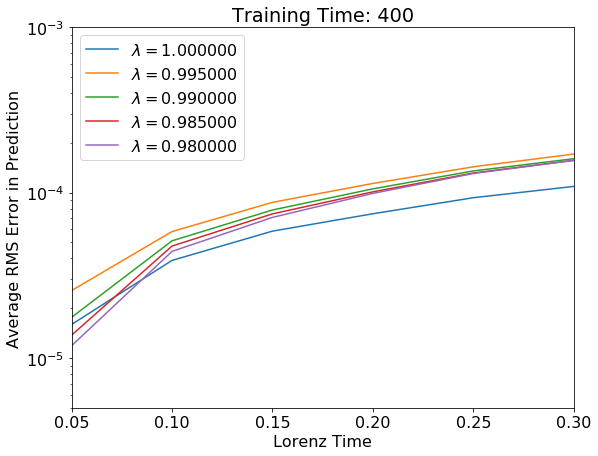

In [32]:
plot_pred = 200
plt.figure(figsize = (9,7))
for i in range(avg_errors.shape[2]):
    if i ==0:
        plt_lambda = 1.
    else:
        plt_lambda = forgets[i-1]
    plt.plot(step*np.arange(avg_errors.shape[0])+step,avg_errors[:,plot_pred,i],label = '$\lambda = %f$' % plt_lambda)
plt.xlabel('Lorenz Time')
plt.ylabel('Average RMS Error in Prediction')
plt.title('Training Time: %d' % (plot_pred*predict_gap_length*step) )
plt.yscale('log')
plt.rc('font',size = 16)
plt.xlim(step,0.3)
plt.ylim(5e-6,1e-3)
plt.legend()
plt.savefig('lorenz_prediction_error_switch1_traintime%d_step%f.pdf' % (plot_pred*predict_gap_length*step, step))
plt.show()

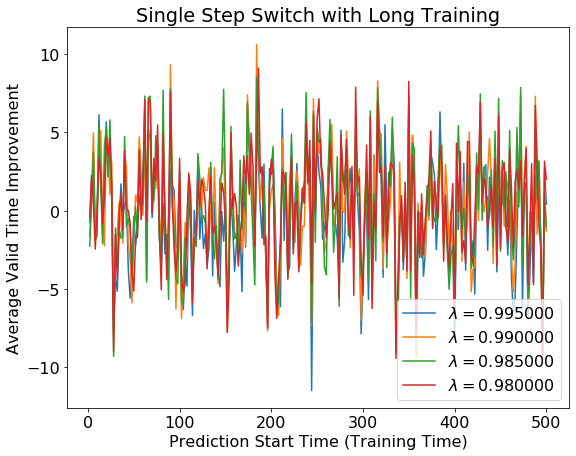

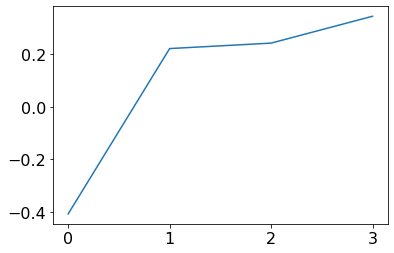

1.306935346526369


In [57]:
avg_valid_times = np.zeros((num_predictions,num_forgets+1))
avg_valid_times[:,1:] = np.mean(valid_times,axis = 1)
temp_valid_times = np.loadtxt('Lorenz63Data/lorenz_valid_times_constr_lam1.000000_tikreg1.000000e-06.csv', delimiter = ',')
avg_valid_times[:,0] = np.mean(temp_valid_times,axis = 1)
times = (np.arange(num_predictions)+1)*predict_gap_length*step
plt.figure(figsize = (9,7))
for i in range(avg_valid_times.shape[1]):
    if i > 0:
        plt_lambda = forgets[i-1]
        plt.plot(times,avg_valid_times[:,i]-avg_valid_times[-1,0],label = '$\lambda = %f$' % plt_lambda)
plt.xlabel('Prediction Start Time (Training Time)')
plt.ylabel('Average Valid Time Improvement')
plt.title('Single Step Switch with Long Training')
plt.rc('font',size = 16)
plt.legend()
plt.savefig('lorenz_valid_time_switch1_long_step%f.pdf' % step)
plt.show()

mean_valid_time_improvement = np.mean(avg_valid_times[:,1:]-avg_valid_times[-1,0], axis = 0)
plt.plot(mean_valid_time_improvement)
plt.show()

In [59]:
np.log(1/2)/np.log(0.995)*0.025

3.457064324651521

In [14]:
predictions_norm = np.zeros((input_size,predict_length,num_predictions,num_trials))
truths_norm = np.zeros((input_size,predict_length,num_predictions,num_trials))
errors_norm = np.zeros((predict_length,num_predictions,num_trials))
valid_times_norm = np.zeros((num_predictions,num_trials))
for data_seed in range(num_trials):
    np.random.seed(data_seed)
    train_input_sequence = getLorenzData(data_length,r_t_const,dxdt_lorenz,tau = 0.05)
    times = np.zeros(num_predictions)

    x = np.zeros(num_nodes)
    # states = np.zeros((num_nodes, start_length))

    for t in range(transient_length-1):
        x = advanceReservoir(win,A_mat,x,train_input_sequence[:,t],leakage)
    
    error_cutoff = 1;
    aug_states = np.zeros((num_nodes,predict_gap_length*num_predictions))
    for pred in range(num_predictions):
        start_pred_idx = transient_length + pred*predict_gap_length-1
        times[pred] = start_pred_idx*step
        for i in range(predict_gap_length):
            x = advanceReservoir(win,A_mat,x,train_input_sequence[:,start_pred_idx + i],leakage)
            aug_x = np.copy(x)
            aug_x[::2] = np.power(x[::2],2)
            aug_states[:,i + pred*predict_gap_length] = aug_x
        data_trstates_norm = train_input_sequence[:,transient_length:transient_length+(pred+1)*predict_gap_length] @ \
                  aug_states[:,:(pred+1)*predict_gap_length].T
        states_trstates_norm = aug_states[:,:(pred+1)*predict_gap_length] @ aug_states[:,:(pred+1)*predict_gap_length].T\
                  + regularization*sparse.identity(num_nodes)
        wout_norm = np.transpose(solve(states_trstates_norm.T,data_trstates_norm.T))



        truths_norm[:,:,pred,data_seed] = train_input_sequence[:,start_pred_idx + predict_gap_length:start_pred_idx + predict_gap_length + predict_length]
        predictions_norm[:,:,pred,data_seed], errors_norm[:,pred,data_seed], valid_times_norm[pred,data_seed] =\
            evaluatePrediction(win, A_mat, wout_norm, x, predict_length, leakage, truths_norm[:,:,pred,data_seed], error_cutoff)
    print(data_seed)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [54]:
print(np.mean(avg_valid_times[:,4]-avg_valid_times[-1,0]))

0.3437599999999882


<function matplotlib.pyplot.show(*args, **kw)>

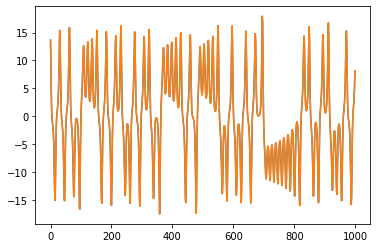

In [71]:
train_out = wout_norm @ aug_states
plt.plot(train_out[0,:1000])
plt.plot(train_input_sequence[0,transient_length:transient_length + 1000])
plt.show

In [35]:
for i in range(num_forgets):
    valid_time_save = valid_times[:,:,i]
    np.savetxt('Lorenz63Data/lorenz_valid_times_constr_lam%f_reg%e.csv' % (forgets[i],LM_reg),valid_time_save,delimiter = ',')

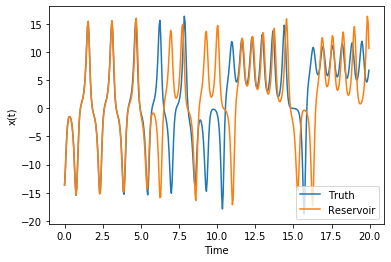

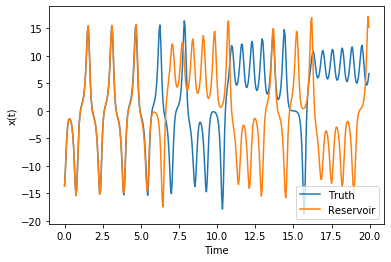

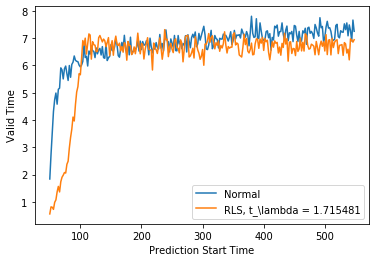

In [46]:
itr = 200
run = 10
fgt = 3
fgtm = step*np.log(1/2)/np.log(forgets[fgt])
plt.plot(np.arange(predict_length)*step,truths_norm[0,:,itr,run],label = 'Truth')
plt.plot(np.arange(predict_length)*step,predictions_norm[0,:,itr,run],label = 'Reservoir')
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.legend()
plt.show()

plt.plot(np.arange(predict_length)*step,truths[0,:,itr,run,fgt],label = 'Truth')
plt.plot(np.arange(predict_length)*step,predictions[0,:,itr,run,fgt],label = 'Reservoir')
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.legend()
plt.show()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """


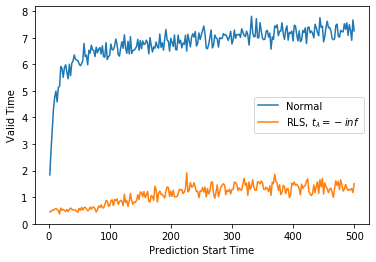

In [41]:
forget = 1
reg = 1e-10
deltaplot = 1e-2
times = np.arange(2,2*251,2)
fgtm = step*np.log(1/2)/np.log(forget)
if deltaplot == 1.:
    valid_time_save = np.loadtxt('Lorenz63Data/lorenz_valid_times_constr_lam%f_reg%e.csv' % (forget,reg),delimiter = ',')
else:
    valid_time_save = np.loadtxt('Lorenz63Data/lorenz_valid_times_constr_lam%f_reg%e_delta%e.csv' % (forget,reg,deltaplot),delimiter = ',')
valid_time_norm_save = np.loadtxt('Lorenz63Data/lorenz_valid_times_norm_rconst_lam%f_tikreg%e.csv' % (1.,regularization),delimiter = ',')
plt.plot(times,np.mean(valid_time_norm_save[:,:],axis = 1)*step,label = 'Normal')
plt.plot(times,np.mean(valid_time_save,axis = 1)*step,label = 'RLS, $t_\lambda = %f$' % fgtm)
plt.xlabel('Prediction Start Time')
plt.ylabel('Valid Time')
plt.legend()
if deltaplot == 1.:
    plt.savefig('lorenz_valid_times_lam%f_reg%e.pdf' % (forget,reg))
else:
    plt.savefig('lorenz_valid_times_lam%f_reg%e_delta%e.pdf' % (forget,reg,deltaplot))
plt.show()

In [146]:
print(times)

[ 49.95  51.95  53.95  55.95  57.95  59.95  61.95  63.95  65.95  67.95
  69.95  71.95  73.95  75.95  77.95  79.95  81.95  83.95  85.95  87.95
  89.95  91.95  93.95  95.95  97.95  99.95 101.95 103.95 105.95 107.95
 109.95 111.95 113.95 115.95 117.95 119.95 121.95 123.95 125.95 127.95
 129.95 131.95 133.95 135.95 137.95 139.95 141.95 143.95 145.95 147.95
 149.95 151.95 153.95 155.95 157.95 159.95 161.95 163.95 165.95 167.95
 169.95 171.95 173.95 175.95 177.95 179.95 181.95 183.95 185.95 187.95
 189.95 191.95 193.95 195.95 197.95 199.95 201.95 203.95 205.95 207.95
 209.95 211.95 213.95 215.95 217.95 219.95 221.95 223.95 225.95 227.95
 229.95 231.95 233.95 235.95 237.95 239.95 241.95 243.95 245.95 247.95
 249.95 251.95 253.95 255.95 257.95 259.95 261.95 263.95 265.95 267.95
 269.95 271.95 273.95 275.95 277.95 279.95 281.95 283.95 285.95 287.95
 289.95 291.95 293.95 295.95 297.95 299.95 301.95 303.95 305.95 307.95
 309.95 311.95 313.95 315.95 317.95 319.95 321.95 323.95 325.95 327.95
 329.9

[ 49.95  51.95  53.95  55.95  57.95  59.95  61.95  63.95  65.95  67.95
  69.95  71.95  73.95  75.95  77.95  79.95  81.95  83.95  85.95  87.95
  89.95  91.95  93.95  95.95  97.95  99.95 101.95 103.95 105.95 107.95
 109.95 111.95 113.95 115.95 117.95 119.95 121.95 123.95 125.95 127.95
 129.95 131.95 133.95 135.95 137.95 139.95 141.95 143.95 145.95 147.95
 149.95 151.95 153.95 155.95 157.95 159.95 161.95 163.95 165.95 167.95
 169.95 171.95 173.95 175.95 177.95 179.95 181.95 183.95 185.95 187.95
 189.95 191.95 193.95 195.95 197.95 199.95 201.95 203.95 205.95 207.95
 209.95 211.95 213.95 215.95 217.95 219.95 221.95 223.95 225.95 227.95
 229.95 231.95 233.95 235.95 237.95 239.95 241.95 243.95 245.95 247.95
 249.95 251.95 253.95 255.95 257.95 259.95 261.95 263.95 265.95 267.95
 269.95 271.95 273.95 275.95 277.95 279.95 281.95 283.95 285.95 287.95
 289.95 291.95 293.95 295.95 297.95 299.95 301.95 303.95 305.95 307.95
 309.95 311.95 313.95 315.95 317.95 319.95 321.95 323.95 325.95 327.95
 329.9

In [55]:
best_valid_times = np.zeros((3,num_predictions))
max_avg_valid_times = np.zeros(num_predictions)
for k in range(num_forgets):
    for LM_reg in LM_regs:
        new_avg_valid_times = np.zeros(num_predictions)
        for data_seed in range(num_trials):
            new_avg_valid_times = new_avg_valid_times + np.loadtxt('Lorenz63Data/lorenz_valid_times_period2000_lam%f_reg%e_seed%d.csv' % (forgets[k],LM_reg,data_seed),delimiter = ',')
        new_avg_valid_times = new_avg_valid_times/num_trials
        max_avg_valid_times = np.maximum(max_avg_valid_times,new_avg_valid_times)
        for pred in range(num_predictions):
            if max_avg_valid_times[pred] == new_avg_valid_times[pred]:
                best_valid_times[0,pred] = data_seed
                best_valid_times[1,pred] = forgets[k]
                best_valid_times[2,pred] = LM_reg

In [59]:
# print(best_valid_times)


{0.9925: 6, 0.9875: 4, 0.9825: 16, 0.98: 54, 0.985: 4, 0.99: 4, 0.995: 12}


In [ ]:
wouts_abs = np.sqrt(np.mean((wouts - wouts_norm)**2,axis = (0,1)))
plt.plot(wouts_abs)
plt.show()

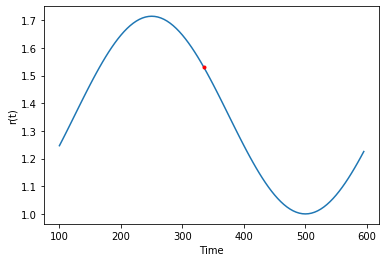

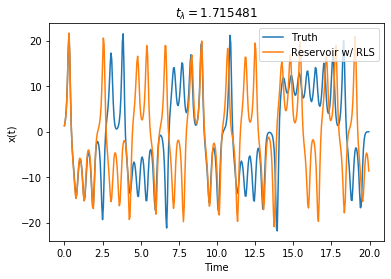

In [17]:
itr = 47
run = 15
fg  = 7
times_all = step*(transient_length + start_length + np.arange(num_predictions)*predict_gap_length)
plt.plot(times_all,r_t_cosine(times))
plt.plot(times[itr],r_t_cosine(times[itr]),'r.')
plt.xlabel('Time')
plt.ylabel('r(t)')
plt.savefig('r_t_cosine_itr%d_run%d_forget%d.pdf' % (itr,run,fg))
plt.show()
plt.plot(np.arange(predict_length)*step,truths[0,:,itr,run,fg],label = 'Truth')
plt.plot(np.arange(predict_length)*step,predictions[0,:,itr,run,fg],label = 'Reservoir w/ RLS')
plt.xlabel('Time')
plt.ylabel('x(t)')
tlfg = step*np.log(1/2)/np.log(forgets[fg])
plt.title('$t_\lambda = %f$' % tlfg)
plt.legend()
plt.savefig('x_t_truth_vs_pred_winnergarbage_itr%d_run%d_forget%d_reg1e-8_wapproxLMreg.pdf' % (itr,run,fg))
plt.show()

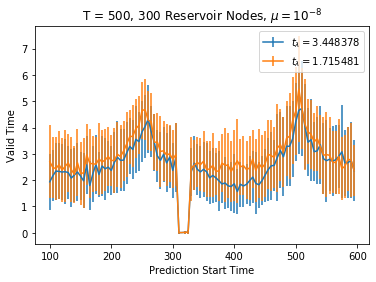

In [22]:
idx1 = 3
tl1 = step*np.log(1/2)/np.log(forgets[idx1])
idx2 = 7
tl2 = step*np.log(1/2)/np.log(forgets[idx2])
# plt.errorbar(times,np.mean(valid_times[:,:,0],axis = 1)*step,step*np.std(valid_times[:,:,0],axis = 1),label = '$t_\lambda = \infty$')
plt.errorbar(times,np.mean(valid_times[:,:,idx1],axis = 1)*step,step*np.std(valid_times[:,:,idx1],axis = 1),label = '$t_\lambda = %f$' % tl1)
plt.errorbar(times,np.mean(valid_times[:,:,idx2],axis = 1)*step,step*np.std(valid_times[:,:,idx2],axis = 1),label = '$t_\lambda = %f$' % tl2)
plt.legend()
plt.xlabel('Prediction Start Time')
plt.ylabel('Valid Time')
plt.title('T = 500, 300 Reservoir Nodes, $\mu = 10^{-8}$')
plt.savefig('valid_time_vs_start_time_winnergarbage_reg1e-8_wapproxLMreg.pdf')
plt.show()

In [ ]:
plt.plot(predictions[0,:,80,5,6])
plt.plot(truths[0,:,80,5,6])
plt.show()